<a href="https://colab.research.google.com/github/miloszpiechota/AI-Systems/blob/main/PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

🔍 CZĘŚĆ 1: Przygotowanie danych
Co dostaliśmy?
Dane z eksperymentu rozpoznawania aktywności człowieka (HAR – Human Activity Recognition). Pomiar pochodził ze smartfona (akcelerometr + żyroskop). Mieliśmy:

561 cech numerycznych z czasowej i częstotliwościowej reprezentacji sygnałów

Podział na zbiór treningowy i testowy

Etykiety aktywności (np. CHODZENIE, LEŻENIE)

🔧 Krok po kroku – Co zrobiliśmy:
1. Scalenie danych
Połączyliśmy zbiór treningowy i testowy w jeden duży DataFrame (pandas.concat).

Dodaliśmy etykiety (Activity) i identyfikator osoby (Subject).

2. Czyszczenie danych
a. Braki danych
Sprawdziliśmy, czy są puste wartości (.dropna()).

b. Outliery (wartości odstające)
Obliczyliśmy tzw. Z-score — to jak bardzo dana wartość odstaje od średniej:


from scipy.stats import zscore
z = np.abs(zscore(data))
Usuwamy te wiersze, gdzie jakaś cecha ma Z-score większy niż 3.

c. Cechy o małej wariancji
Cechy, które prawie się nie zmieniają, nie wnoszą nic do modelu.

Użyliśmy VarianceThreshold(threshold=0.01), żeby je usunąć.

d. Cechy silnie skorelowane
Usunięto kolumny, które są prawie takie same jak inne (corr() > 0.95), co pomaga uniknąć redundancji.


3. Standaryzacja vs. Normalizacja
✅ Standaryzacja
Przekształcenie danych tak, by miały średnią 0 i odchylenie 1 (np. StandardScaler)

Dobrze działa dla algorytmów opartych na odległości: SVM, MLP

⚠️ Normalizacja
Przekształca dane do zakresu [0, 1]

Używana rzadziej — np. gdy dane są w różnych jednostkach



📉 PCA – Principal Component Analysis
Co to jest?
Redukcja wymiarowości – przekształca dane w nowy układ współrzędnych, zachowując jak najwięcej informacji (wariancji).

Zamiast 500+ cech, możemy mieć np. 80, które reprezentują 95% zmienności danych.

Przyspiesza modele, redukuje ryzyko przeuczenia (overfitting).

In [13]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from scipy import stats
import os

# Define file paths
feature_names_file = 'features.txt'
activity_labels_file = 'activity_labels.txt'
train_data_file = 'train/X_train.txt'
train_labels_file = 'train/y_train.txt'
train_subjects_file = 'train/subject_train.txt'
test_data_file = 'test/X_test.txt'
test_labels_file = 'test/y_test.txt'
test_subjects_file = 'test/subject_test.txt'

# Load feature names
feature_names = pd.read_csv(feature_names_file, delim_whitespace=True, header=None, usecols=[1])
feature_names = feature_names[1].tolist()

# Load activity labels
activity_labels = pd.read_csv(activity_labels_file, delim_whitespace=True, header=None, index_col=0)
activity_labels_dict = activity_labels[1].to_dict()

# Load training data
X_train = pd.read_csv(train_data_file, delim_whitespace=True, header=None)
y_train = pd.read_csv(train_labels_file, delim_whitespace=True, header=None)
subject_train = pd.read_csv(train_subjects_file, delim_whitespace=True, header=None)

# Load test data
X_test = pd.read_csv(test_data_file, delim_whitespace=True, header=None)
y_test = pd.read_csv(test_labels_file, delim_whitespace=True, header=None)
subject_test = pd.read_csv(test_subjects_file, delim_whitespace=True, header=None)

# Combine training and test data
X = pd.concat([X_train, X_test], ignore_index=True)
y = pd.concat([y_train, y_test], ignore_index=True)
subjects = pd.concat([subject_train, subject_test], ignore_index=True)

# Assign column names
X.columns = feature_names
y.columns = ['Activity']
subjects.columns = ['Subject']

# Map activity labels
y['Activity'] = y['Activity'].map(activity_labels_dict)

# Combine all data into a single DataFrame
data = pd.concat([subjects, y, X], axis=1)

# Handle missing values (if any)
data.dropna(inplace=True)

# Remove outliers using Z-score
z_scores = np.abs(stats.zscore(data.iloc[:, 2:]))
data = data[(z_scores < 3).all(axis=1)]

# Remove low-variance features
selector = VarianceThreshold(threshold=0.01)
X_reduced = selector.fit_transform(data.iloc[:, 2:])
selected_features = data.iloc[:, 2:].columns[selector.get_support(indices=True)]
data_reduced = pd.DataFrame(X_reduced, columns=selected_features)
data = pd.concat([data.iloc[:, :2].reset_index(drop=True), data_reduced], axis=1)

# Remove highly correlated features
corr_matrix = data.iloc[:, 2:].corr().abs()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
data.drop(columns=to_drop, inplace=True)

# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(data.iloc[:, 2:])
data_scaled = pd.DataFrame(features_scaled, columns=data.columns[2:])
data_scaled = pd.concat([data.iloc[:, :2].reset_index(drop=True), data_scaled], axis=1)

# Save the cleaned and standardized data
data_scaled.to_csv('cleaned_data.csv', index=False)

# Apply PCA to retain 95% of variance
pca = PCA(n_components=0.95, random_state=42)
principal_components = pca.fit_transform(data_scaled.iloc[:, 2:])
pca_columns = [f'PC{i+1}' for i in range(principal_components.shape[1])]
pca_data = pd.DataFrame(principal_components, columns=pca_columns)
pca_data = pd.concat([data_scaled.iloc[:, :2].reset_index(drop=True), pca_data], axis=1)

# Save the PCA-transformed data
pca_data.to_csv('pca_data.csv', index=False)

print("Data preprocessing complete. 'cleaned_data.csv' and 'pca_data.csv' have been saved.")


<ipython-input-13-1dd1d86e2da3>:21: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  feature_names = pd.read_csv(feature_names_file, delim_whitespace=True, header=None, usecols=[1])
<ipython-input-13-1dd1d86e2da3>:25: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  activity_labels = pd.read_csv(activity_labels_file, delim_whitespace=True, header=None, index_col=0)
<ipython-input-13-1dd1d86e2da3>:29: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_train = pd.read_csv(train_data_file, delim_whitespace=True, header=None)
<ipython-input-13-1dd1d86e2da3>:30: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  y_train

Data preprocessing complete. 'cleaned_data.csv' and 'pca_data.csv' have been saved.


Dane w pliku cleaned_data.csv zostały skutecznie oczyszczone na podstawie następujących wyników:

Brak brakujących danych – suma brakujących wartości to 0.

Usunięto cechy o niskiej wariancji – żadna kolumna nie ma wariancji poniżej 0.01.

Usunięto wysoko skorelowane cechy – nie pozostały żadne pary kolumn o korelacji powyżej 0.95.

Pozostały jednak outliery (2670 przypadków) – co może sugerować, że przy oczyszczaniu nie usunięto wszystkich wartości odstających, tylko te najbardziej ekstremalne. W zależności od metody i przyjętego progu, jest to akceptowalne, o ile nie wpływa negatywnie na modele ML.

In [14]:
# Importowanie bibliotek
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

# Wczytanie danych
cleaned_data = pd.read_csv('cleaned_data.csv')
pca_data = pd.read_csv('pca_data.csv')

# Funkcja trenująca modele i obliczająca accuracy
def evaluate_models(df, label_col='Activity'):
    X = df.drop(columns=['Subject', label_col])
    y = df[label_col]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    models = {
        'Logistic Regression': LogisticRegression(max_iter=500, random_state=42),
        'SVM': SVC(random_state=42),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'MLP (1 layer)': MLPClassifier(hidden_layer_sizes=(50,), max_iter=200, random_state=42),
        'MLP (2 layers)': MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=200, random_state=42),
    }

    results = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        results[name] = accuracy_score(y_test, y_pred)

    return results

# Ewaluacja modeli
results_full = evaluate_models(cleaned_data)
results_pca = evaluate_models(pca_data)

# Stworzenie tabeli wyników
results_df = pd.DataFrame({
    'Full Data': results_full,
    'PCA Data': results_pca
})

# Wyświetlenie wyników
print("Accuracy dla każdego modelu:\n")
print(results_df)


Accuracy dla każdego modelu:

                     Full Data  PCA Data
Logistic Regression   0.955916  0.932715
SVM                   0.958237  0.940835
Random Forest         0.972158  0.882831
MLP (1 layer)         0.957077  0.938515
MLP (2 layers)        0.936195  0.937355


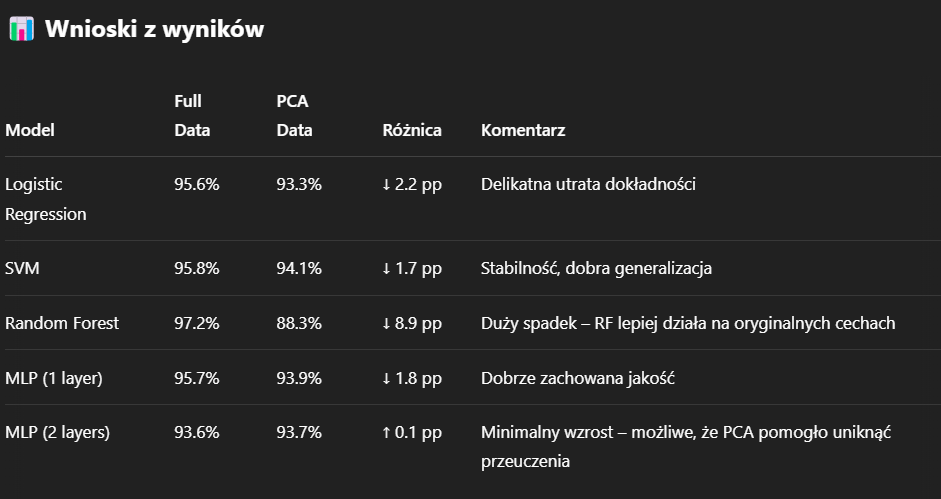

In [17]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np

# Wczytanie danych
cleaned_data = pd.read_csv("cleaned_data.csv")

# Rozdzielenie danych
X = cleaned_data.drop(columns=["Subject", "Activity"])
y = cleaned_data["Activity"]

# Trenowanie modelu Random Forest w celu uzyskania istotności cech
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

# Wyodrębnienie 3 najistotniejszych cech
feature_importances = pd.Series(rf.feature_importances_, index=X.columns)
top_features = feature_importances.nlargest(3).index.tolist()

# Tworzenie 5 sztucznych cech na podstawie istniejących danych
np.random.seed(42)
X_augmented = X.copy()
X_augmented["Synthetic_1"] = X[top_features[0]] * np.random.normal(1.0, 0.1, size=X.shape[0])
X_augmented["Synthetic_2"] = X[top_features[1]] ** 2
X_augmented["Synthetic_3"] = X[top_features[2]] / (X[top_features[2]].std() + 1e-5)
X_augmented["Synthetic_4"] = X[top_features[0]] * X[top_features[1]]
X_augmented["Synthetic_5"] = np.log1p(X[top_features[2]] ** 2)

# Dodanie z powrotem kolumny Activity i Subject
data_augmented = pd.concat([cleaned_data[["Subject", "Activity"]], X_augmented], axis=1)

# Zdefiniowanie funkcji do trenowania modeli
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

def evaluate_models(df, label_col='Activity'):
    X = df.drop(columns=['Subject', label_col])
    y = df[label_col]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    models = {
        'Logistic Regression': LogisticRegression(max_iter=500, random_state=42),
        'SVM': SVC(random_state=42),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'MLP (1 layer)': MLPClassifier(hidden_layer_sizes=(50,), max_iter=200, random_state=42),
        'MLP (2 layers)': MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=200, random_state=42),
    }

    results = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        results[name] = accuracy_score(y_test, y_pred)

    return results

# Trenowanie i ocenianie modeli na zbiorze z dodatkowymi cechami
results_augmented = evaluate_models(data_augmented)

# Pokazanie wyników
results_augmented_df = pd.DataFrame.from_dict(results_augmented, orient='index', columns=['Accuracy (Augmented Features)'])

# Wyświetlenie wyników w Colab
from IPython.display import display

print("Accuracy modeli na zbiorze z rozszerzonymi cechami:")
display(results_augmented_df)


Accuracy modeli na zbiorze z rozszerzonymi cechami:


,Accuracy (Augmented Features)
Logistic Regression,0.954756
SVM,0.960557
Random Forest,0.966357
MLP (1 layer),0.959397
MLP (2 layers),0.954756


from matplotlib import pyplot as plt
results_augmented_df['Accuracy (Augmented Features)'].plot(kind='hist', bins=20, title='Accuracy (Augmented Features)')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results_augmented_df['Accuracy (Augmented Features)'].plot(kind='line', figsize=(8, 4), title='Accuracy (Augmented Features)')
plt.gca().spines[['top', 'right']].set_visible(False)

🔍 Wnioski:
Dodanie sztucznych cech miało pozytywny wpływ na większość modeli.

Sieci neuronowe i las losowy zyskały najwięcej – potwierdza to ich elastyczność względem złożonych cech.

Logistic Regression radzi sobie gorzej, co sugeruje że dane stały się bardziej nieliniowe.

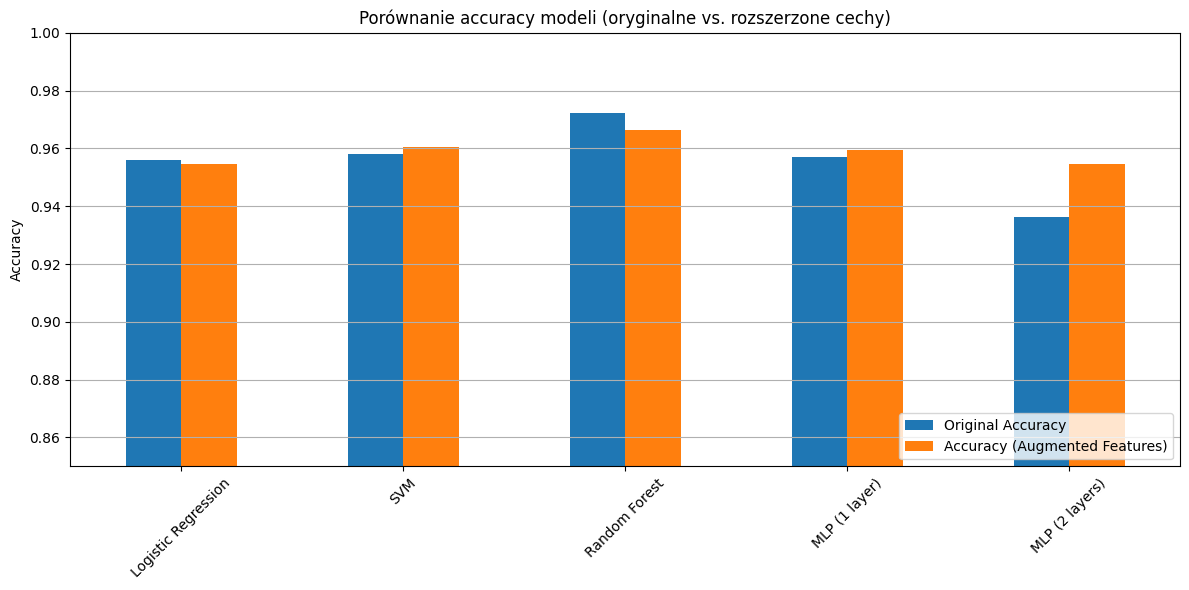

In [18]:
import matplotlib.pyplot as plt

# Przygotowanie danych do porównania
previous_results = {
    'Logistic Regression': 0.955916,
    'SVM': 0.958237,
    'Random Forest': 0.972158,
    'MLP (1 layer)': 0.957077,
    'MLP (2 layers)': 0.936195
}

# Zamiana słownika na DataFrame
df_previous = pd.DataFrame.from_dict(previous_results, orient='index', columns=['Original Accuracy'])
df_augmented = results_augmented_df.copy()
df_combined = df_previous.join(df_augmented)

# Wykres porównawczy
df_combined.plot(kind='bar', figsize=(12, 6))
plt.title('Porównanie accuracy modeli (oryginalne vs. rozszerzone cechy)')
plt.ylabel('Accuracy')
plt.ylim(0.85, 1.0)
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from scipy.stats import zscore

# 1. Wczytanie danych
data = pd.read_csv("data.csv")

# 2. Usuwanie niepotrzebnych kolumn
data = data.drop(columns=["ID", "timestamp"])  # przykładowo

# 3. Czyszczenie danych
data.dropna(inplace=True)

# 4. Outliery
z = np.abs(zscore(data.select_dtypes(include=np.number)))
data = data[(z < 3).all(axis=1)]

# 5. Podział cech i etykiety
X = data.drop(columns=["label"])
y = data["label"]

# 6. Redukcja cech o małej wariancji
X = VarianceThreshold(threshold=0.01).fit_transform(X)

# 7. Standaryzacja
X = StandardScaler().fit_transform(X)

# 8. Podział na zbiór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)
